In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Ongoing Device : {device}')


Ongoing Device : cuda


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = MNIST(root='./data', transform=transform, download=True)
test_dataset  = MNIST(root='./data', transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

In [16]:
# get 25 sample training images for visualization
dataiter = iter(train_loader)
image = dataiter.next()

num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)] 

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

AttributeError: '_SingleProcessDataLoaderIter' object has no attribute 'next'

In [5]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

In [6]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

In [7]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [8]:
batch_size = 100
def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, -1).to(device)

            optimizer.zero_grad()
            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

train(model, optimizer, epochs=50, device=device)

	Epoch 1 	Average Loss:  175.36714025328672
	Epoch 2 	Average Loss:  156.40826525654737
	Epoch 3 	Average Loss:  152.0791394511686
	Epoch 4 	Average Loss:  149.13160314391172
	Epoch 5 	Average Loss:  146.86234296744576
	Epoch 6 	Average Loss:  145.21349117017945
	Epoch 7 	Average Loss:  143.8407674248748
	Epoch 8 	Average Loss:  142.87940814443343
	Epoch 9 	Average Loss:  142.0864309004591
	Epoch 10 	Average Loss:  141.3020151750313
	Epoch 11 	Average Loss:  140.58415609674978
	Epoch 12 	Average Loss:  140.14075258895033
	Epoch 13 	Average Loss:  139.5741296692404
	Epoch 14 	Average Loss:  139.2204271931083
	Epoch 15 	Average Loss:  138.8309564606375
	Epoch 16 	Average Loss:  138.37976510329716
	Epoch 17 	Average Loss:  138.05899779254486
	Epoch 18 	Average Loss:  137.9559701227306
	Epoch 19 	Average Loss:  137.4709928820169
	Epoch 20 	Average Loss:  137.3253860764034
	Epoch 21 	Average Loss:  137.0800257427744
	Epoch 22 	Average Loss:  136.6849799959568
	Epoch 23 	Average Loss:  136.6

7957622.6181640625

In [9]:
torch.save(model.state_dict(), f'checkpoints/VAES/ckpt.pth')

In [10]:
def plot_latent_space(model, scale=5.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

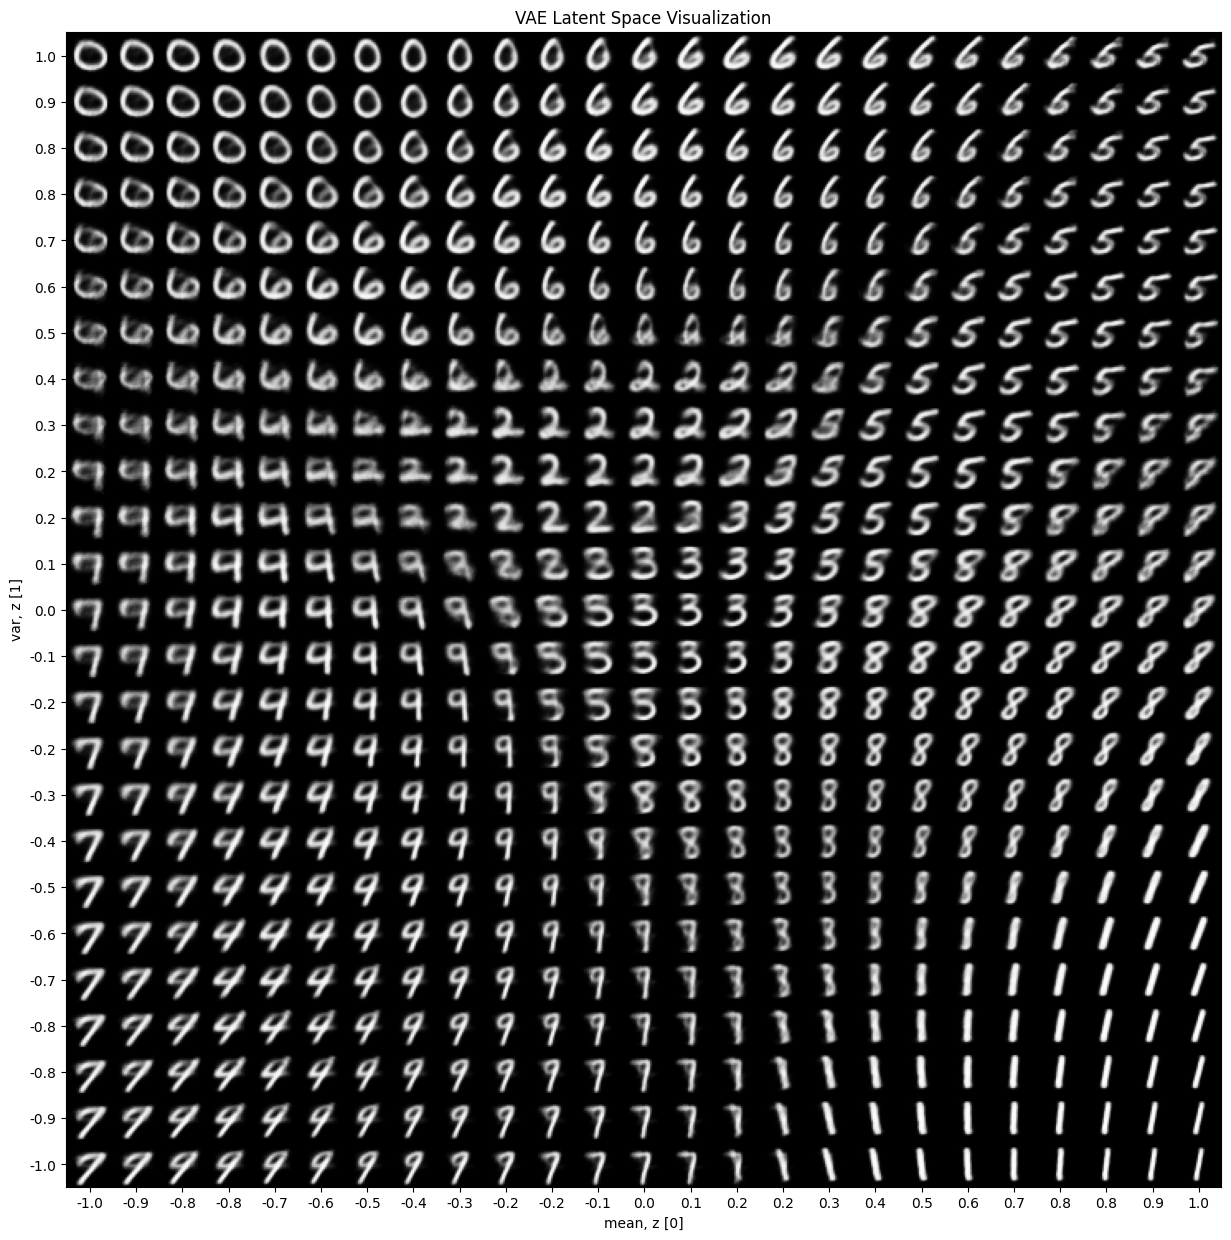

In [11]:
plot_latent_space(model, scale=1.0)